In [ ]:
cnt = 0
for user in submissions:
    for problem in submissions[user]:
        cnt+=len(submissions[user][problem])

Process json

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import Process, Lock
from tqdm import tqdm

import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
data = getJsonData("processed.json")
ans = 0
for user in tqdm(data.keys()):
    for problem_id in data[user].keys():
        ans+=len(data[user][problem_id])
print("total data = ", ans)

In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import Process, Lock
from tqdm import tqdm

import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
    

cached_data/          evaluation.log             result.txt   test.output
checkpoint-best-ppl/  generation_evaluation.log  summary.log  test.src
checkpoint-last/      generation.json            test.gold    training.log


In [3]:
data = getJsonData('../codet5/codenet/java2java/generation.json')

In [4]:
len(data)

500

{'idx': 499,
 'tgt': 'import java . util . Arrays ; import java . util . Scanner ; public class Main { public static void main ( String [ ] args ) { try ( Scanner sc = new Scanner ( System . in ) ; ) { new Main ( ) . solve ( sc ) ; } } void solve ( Scanner sc ) { int n = sc . nextInt ( ) ; Point [ ] ps = new Point [ n ] ; for ( int i = 0 ; i < n ; i ++ ) { long x = sc . nextLong ( ) ; long y = sc . nextLong ( ) ; long h = sc . nextLong ( ) ; if ( h == 100 ) { System . out . printf ( " % d ▁ % d ▁ % d % n " , x , y , h ) ; return ; } ps [ i ] = new Point ( x , y , h ) ; } Arrays . sort ( ps , ( x , y ) -> { if ( y . h == x . h ) { return 0 ; } else if ( y . h > x . h ) { return 1 ; } return - 1 ; } ) ; for ( int x = 0 ; x <= 100 ; x ++ ) { for ( int y = 0 ; y <= 100 ; y ++ ) { long h = ps [ 0 ] . h + Math . abs ( ps [ 0 ] . x - x ) + Math . abs ( ps [ 0 ] . y - y ) ; for ( int k = 0 ; k < n ; k ++ ) { long h1 = Math . max ( h - Math . abs ( ps [ k ] . x - x ) - Math . abs ( ps [ k ] . y

In [ ]:
#cat ../Project_CodeNet/data/p00220/Java/s289306249.java
#cat ../Project_CodeNet/data/p00442/Java/s813585875.java
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor

root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)
#sol = "../Project_CodeNet/data/p00220/Java/s289306249.java"
#sol = "exceptional_case.java"
sol = "../Project_CodeNet/data/p04049/Java/s881422316.java"

with open(sol, 'r', encoding='utf8') as f:
    code = f.read()
    print(code.strip())
    code_tokens_java = jprocessor.tokenize_code(code)
    fn_standalone_java, fn_class_java = jprocessor.extract_functions(code_tokens_java)
    print(fn_standalone_java, fn_class_java)
    functions_standalone_java = [(jprocessor.get_function_name(fn), fn) for fn in fn_standalone_java]
    functions_class_java = [(jprocessor.get_function_name(fn), fn) for fn in fn_class_java]

In [ ]:
with open('exceptional_case.java', 'r', encoding='utf8') as f:
    code = f.read()
    print(code)

In [ ]:
with open("python_solutions.jsonl", 'r') as f:
    for line in f:
        ex = json.loads(line)
        pprint(ex[1])
        break

In [ ]:
cp ../Project_CodeNet/data/p00220/Java/s289306249.java exceptional_case.java

In [ ]:
ls

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import Process, Lock
from tqdm import tqdm
import os
import json
import threading

def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data

data = getJsonData("processed.json")
ans = 0
for user in tqdm(data.keys()):
    for problem_id in data[user].keys():
        ans+=len(data[user][problem_id])
print("total data = ", ans)


Some statistics

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import Process, Lock
from tqdm import tqdm

import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
data = getJsonData("processed.json")
ans = 0
for user in tqdm(data.keys()):
    for problem_id in data[user].keys():
        ans+=len(data[user][problem_id])
print("total data = ", ans)

In [ ]:
import matplotlib.pyplot as plt
Problem_count = 0

lang_count = 0
path_sum = 0
solved_be_user = 0

path_lengths = []
submission_counts = []
lang_counts = []
for user in tqdm(list(data.keys())):
    language_lst=set()
    submission_count = 0
    for problem_id in data[user].keys():
        path_len = 0
        if(len(data[user][problem_id])):
            Problem_count+=1
        
        langs = {}
        for idx, subs in enumerate(data[user][problem_id]):
            # need to consider for each language
            if subs[2] in langs.keys():
                langs[subs[2]].append(subs)
            else:
                langs[subs[2]] = [subs]
            language_lst.add(subs[2])
            submission_count+=1
        
        # Path sum calculation
        for lang in langs:
            first_wa = 0
            first_ac = -1
            for idx, sub in enumerate(sorted(langs[lang], key=lambda x: x[1])):
                if(sub[-1]=="Accepted"):
                    first_ac = max(first_ac, idx)
                else:
                    first_wa = min(first_wa, idx)
        
            if(first_ac-first_wa+1>0):
                #print(langs[lang])
                #print(first_ac-first_wa)    
                path_sum+=first_ac-first_wa+1
                solved_be_user+=1
                path_lengths.append(first_ac-first_wa+1)

            
    lang_count+=len(language_lst)
    lang_counts.append(len(language_lst))
    submission_counts.append(submission_count)
        
    #break
print("per user average submission count", sum(submission_counts)/len(data))
print("per user average language usage count", lang_count/len(data))
print("per user average accepted path length", path_sum/solved_be_user)
'''
per user average submission count 90.26494052329126
per user average language usage count 1.4337000090804135
per user average accepted path length 1.9145810148516795
'''

In [ ]:
n_bins=10
n, bins, patches = plt.hist(path_lengths, bins=[i for i in range(11)])
ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [i for i in range(n_bins)]
plt.xticks(ticks, ticklabels)
plt.xlabel("Number of submissions before accepted")
plt.ylabel("Number of users")
plt.show()

In [ ]:
n_bins=10
n, bins, patches = plt.hist(lang_counts, bins=[i for i in range(11)])
ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [i for i in range(n_bins)]
plt.xticks(ticks, ticklabels)
plt.xlabel("Number of Languages used by a user")
plt.ylabel("Number of users")
plt.show()

In [ ]:

n, bins, patches = plt.hist(submission_counts, bins=[i for i in range(200)])
#ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
#ticklabels = [i for i in range(n_bins)]
#plt.xticks(ticks, ticklabels)
plt.xlabel("Number of Submissons per user")
plt.ylabel("Number of users")
plt.show()

In [ ]:
submission_counts[:100]

In [ ]:
import json
from glob import glob

files = "../data/java/jsons/"
src_sizes = []
tgt_sizes = []
for file in glob(files+'*.json'):
    print(file)
    with open(file, 'r') as f:
        temp = json.load(f)
        for ex in temp:
            src_sizes.append(len(ex[0]['code_tokens']))
            tgt_sizes.append(len(ex[1]['code_tokens']))

In [ ]:
import matplotlib.pyplot as plt
plt.hist(src_sizes, bins=[i for i in range(0, 10000, 1000)])
plt.show()

In [ ]:
root = "../../BIFI/"

In [ ]:
import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
data = getJsonData("../../BIFI/data/orig_bad_code/orig.bad.json")

In [ ]:
from pprint import pprint
for key in list(data.keys())[:2]:
    pprint(data[key])

In [ ]:
import json
from glob import glob
from pprint import pprint
file = "../data/java/processed/train.jsonl"

with open(file, 'r') as f:
    train = json.load(f)
print(len(train))
    

In [ ]:
from pprint import pprint
from tqdm import tqdm
from difflib import SequenceMatcher
def calculate_similarity(code1_tokens, code2_tokens):
    code1 = ' '.join(code1_tokens)
    code2 = ' '.join(code2_tokens)
    return SequenceMatcher(None, code1, code2).ratio()
dis = []
for dt in tqdm(train):
    dis.append(calculate_similarity(dt['src'], dt['tgt']))


In [ ]:
import matplotlib.pyplot as plt
plt.hist(dis, bins=5)
plt.show()

In [ ]:
from glob import glob
problem_desc = []
for file in glob("../Project_CodeNet/problem_descriptions/*html"):
    problem_desc.append(file)

In [ ]:
problem_desc[0]

In [ ]:
try: 
    from BeautifulSoup import BeautifulSoup
except ImportError:
    from bs4 import BeautifulSoup
Base_link = "https://www.dropbox.com/sh/nx3tnilzqz7df8a/AAAYlTq2tiEHl5hsESw6-yfLa?dl=0"
import requests
req = requests.get(Base_link)
#print(html)
soup = BeautifulSoup(req.text, "html.parser")
for a in soup.find_all('a', href=True):
    print("Found the URL:", a['href'])

In [ ]:
Access_token = "sl.BBQsZOVExLY-32FcgPQGwk5yMVeJCjShnddXfJGjzAnj0CQ-5GlVrRO39hPX7lP6BnpyFw1_3pE7wPwWsorCjTSwTRRiBqMkGB2q1KMmjPgrD78wu2lHpbrPA_xRQlWZ42oxz2o"

In [ ]:
import re
pattern = "https://www.dropbox.com/sh/nx3tnilzqz7df8a/.*/.*dl=0"

re.findall(r'{}'.format(pattern),req.text)

In [ ]:
import subprocess

def download_and_extract(lnk):
    lnk = lnk.replace("?dl=0", "?dl=1")
    name = lnk.split("/")[-1]
    name = name.split("?dl=1")[0]+".zip"
    #print(name)
    subprocess.run(["wget", "-O", name, lnk])
    subprocess.run(["unzip",name ,"-d","atcoder_test_cases/"+name.replace(".zip", "")])
    subprocess.run(["rm" ,"-rf",name])
    
    

In [ ]:
from tqdm import tqdm
with open("atcoder_links.txt") as f:
    links = f.readlines()
for link in tqdm(links):
    download_and_extract(link)

In [ ]:
import pandas as pd
problemlist=pd.read_csv("../Project_CodeNet/metadata/problem_list.csv")


In [ ]:
from collections import defaultdict
from pprint import pprint
from tqdm import tqdm
problems = defaultdict(list)
for index, row in tqdm(problemlist.iterrows()):
    if(row['dataset']=='AtCoder'):
        if("AtCoder Regular Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ARC"+number].append(row['id'])
        if("AtCoder Beginner Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ABC"+number].append(row['id'])
        if("AtCoder Grand Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["AGC"+number].append(row['id'])

In [ ]:
from glob import glob
folders = glob("atcoder_test_cases/*")

final_keys = []
for idx in range(len(folders)):
    folders[idx] = folders[idx].replace("atcoder_test_cases/", "")
#print(folders)
for key in problems.keys():
    if key in folders:
        if len(problems[key]) == len(glob("atcoder_test_cases/"+key+"/*")):
            final_keys.append(key)
            
    elif key.lower() in folders :
        if len(problems[key]) == len(glob("atcoder_test_cases/"+ key.lower() +"/*")):
            final_keys.append(key)


In [ ]:
problemid_to_tc = {}
for key in problems:
    if(key in final_keys):
        for idx, prob_id in enumerate(problems[key]):
            folder_list = glob("atcoder_test_cases/"+key+"/*")
            if(len(folder_list)==0):
                folder_list = glob("atcoder_test_cases/"+key.lower()+"/*")
            problemid_to_tc[prob_id] = folder_list[idx]

In [ ]:
len(problemid_to_tc)

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import Process, Lock
from tqdm import tqdm

import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
data = getJsonData("../data/java/processed/test.jsonl")


In [ ]:
#data[0]
#def run_and_report()

#st = "atcoder_test_cases/ABC118/B/in/3_mmin_1"
#out = st.split("/")
#out[3] = "out"
#"/".join(out)

In [ ]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys

def check_floating(n1, n2):
    n1 = n1.replace("-", "").replace("+", "")
    n2 = n2.replace("-", "").replace("+", "")
    
    if (not n1.replace('.','',1).replace("E","").isdigit()) or (not n1.replace('.','',1).replace("E","").isdigit()):
        return False
    if abs(float(n1)-float(n2))<1e8:
        return True
    return False
    
def print_error(l1, l2):
    print("###")
    print(l1)
    print("###")
    print(l2)
    print("###")

def compare_files(file1, file2):
    with open(file1) as f1, open(file2) as f2: 
        content1 = f1.read().split()
        content2 = f2.read().split()

        for l1, l2 in zip(content1, content2):
            if l1.strip() != l2.strip(): 
                num1s = l1.strip().split(" ")
                num2s = l2.strip().split(" ")
                if(len(num1s) == len(num2s)):
                    for idx in range(len(num1s)):
                        if not check_floating(num1s[idx],num2s[idx]):
                            print_error(l1, l2)
                            return False
                else:
                    print_error(l1, l2)
                    return False
    return True

root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)

uniq = set()

#code_tokens_java = jprocessor.tokenize_code(code)
cnt = 0
done = False
for dt in tqdm(data[12475:]): #12480+721 14975
    if dt['id'].split("_")[0] in problemid_to_tc.keys():
        #if(dt['tgt_id'].split("_")[1] != "s473235135"):
        #    continue
        cnt+=1
        #print("comes")
        #print(dt['id'])
        #pprint(dt)
        #print(dt['src'])
        code = jprocessor.detokenize_code(dt['tgt'])
        if dt['tgt_id'] in uniq:
            continue
        uniq.add(dt['tgt_id'])
        with open('Main.java', 'w', encoding='utf8') as fw:
            fw.write(code)
        test_case_folder = problemid_to_tc[dt['id'].split("_")[0]]
        in_files = glob(test_case_folder+"/in/*")
        p1 = subprocess.run(["javac","Main.java"])
        return_code = p1.returncode

        if(return_code):
            print("######## doesnt compile  ############")
            print(p1.stderr.decode("utf-8")) 14975
            print(dt['tgt_id'])
            #pprint(dt)
            #doesn't compile correctly

        for in_file in in_files:
            #subprocess.run(["java","Main" ,"<",in_files[0], ">", "cmd_out.txt"], shell=True)
            cmd = "java Main < {} > cmd_out.txt".format(in_file)
            p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
            p.wait()
            #output = p.stdout
            #print(output)
            out = in_file.split("/")
            out[3] = "out"
            out_file ="/".join(out)
            out_file = out_file.replace(".in", ".out")

            p2 = subprocess.Popen(["cp",out_file, "cmd_out_match.txt"])
            p2.wait()
            #match 
            #print(filecmp.cmp('cmd_out.txt', 'cmd_out_match.txt'))
            if not compare_files('cmd_out.txt', 'cmd_out_match.txt'):
                #done=True
                print(dt['tgt_id'])
                #break
                print(in_file)
        p3 = subprocess.run(["rm","Main.java"])
        p4 = subprocess.run(["rm","*.class"])
#print(cnt)

#accept one valid way we need to skip those p02697,
#used weird library runs on jdk 1.8 but not in jdk 11 p02682_s116318276

In [ ]:
s = "p03334,p02678,p02690,p02692,p02697,p02850,p02825,p02902,p02903,p02976,p02977,p03097,p03938,p03245,p03044,p02972,p03263,p03836,p03267,p03257,p03394,p03952,p04007,p04035,p03746,p02963,p03095,p02669,p02825,p03046,p02997,p02936, p02694, p02975,p02731, p02861,p03110"
print(list(set(s.replace(" ", "").split(","))))

In [ ]:
p1 = subprocess.Popen(["javac","Main.java"])
return_code = p1.wait()
print(return_code)

In [ ]:
cmd = "java Main < atcoder_test_cases/ABC138/D/in/b04 > cmd_out.txt"
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=subprocess.DEVNULL, close_fds=True)
p.wait()
print("command exucuted")

in_file = "atcoder_test_cases/ABC138/D/in/b04"
out = in_file.split("/")
out[3] = "out"
out_file ="/".join(out)
out_file = out_file.replace(".in", ".out")

p2 = subprocess.Popen(["cp",out_file, "cmd_out_match.txt"])
p2.wait()
print("Matching Files")

if not compare_files('cmd_out.txt', 'cmd_out_match.txt'):
    #done=True
    #print(dt['tgt_id'])
    print(in_file)

In [ ]:
#One such Way p02678,p02690,p02692,p02697,p02850,p02825,p02902,p02903,p02976,p02977,p03097,p03938,p03245,p03044,p02972
#One such way p03263,p03836,p03267,p03257,p03394,p03952,p04007,p04035,p03746,p02963,p03095,p02669,p02825,p03046,p02997

# p02936, p02694 p02975 one after contest doesn't match
#p02731 has higher thresholds for checking double value, p02861,p03110 as well

'''
Need to check 

p02912_s201342530
atcoder_test_cases/ABC141/D/in/testcase_03.nkftmpjKHWPL
this has one weird input which i deleted from the atcoder_testcases folder

'''

###
#num1 = "0.0000000000000001E-5"
#num2 = "-0.0000000000000001E-5"

#num1 = "1.1551382117326875E-5"
#num2 = "0.00001155138223854135\n"

###
#756.26049783473536042289
num1 = "3.57508992E8"
###
num2 = "357508993.7616"
def only_digits(num):
    return num.replace("-", "").replace("+", "").replace('.','',1).replace("E","").isdigit()

def check_floating(n1, n2):
    if (not only_digits(n1)) or (not only_digits(n2)):
        return False
    print(float(n1), float(n2))
    if abs(float(n1)-float(n2))<1e-6:
        return True
    return False
    
num1s = num1.strip().split(" ")
num2s = num2.strip().split(" ")
if(len(num1s) != len(num2s)):
    print("Not equal")
for idx in range(len(num1s)):
    print(check_floating(num1s[idx],num2s[idx]))


In [ ]:
float("0.00001155138223854135")

In [ ]:
def check_floating(n1, n2):
    n1 = n1.replace("-", "").replace("+", "")
    n2 = n2.replace("-", "").replace("+", "")
    
    if (not n1.replace('.','',1).replace("E","").isdigit()) or (not n1.replace('.','',1).replace("E","").isdigit()):
        return False
    if abs(float(n1)-float(n2))<1e8:
        return True
    return False
    
def print_error(l1, l2):
    print("###")
    print(l1)
    print("###")
    print(l2)
    print("###")

def compare_files(file1, file2):
    try:
        with open(file1) as f1, open(file2) as f2: 
            content1 = f1.read().split()
            content2 = f2.read().split()
            for l1, l2 in zip(content1, content2):
                if l1.strip() != l2.strip(): 
                    num1s = l1.strip().split(" ")
                    num2s = l2.strip().split(" ")
                    if(len(num1s) == len(num2s)):
                        for idx in range(len(num1s)):
                            if not check_floating(num1s[idx],num2s[idx]):
                                print_error(l1, l2)
                                return False
                    else:
                        print_error(l1, l2)
                        return False
            return True
    except Exception as e:
        print("exception = ", e)
        return False


In [ ]:
!head atcoder_test_cases/ABC157/A/out/01-handmade-01
p02658_s473235135

In [ ]:
#!rm temp.java
p03037_s170937198
!cp ../Project_CodeNet/data/p02658/Java/s473235135.java temp2.java

In [ ]:
def check_floating(n1, n2):
    n1 = n1.replace("-", "").replace("+", "")
    n2 = n2.replace("-", "").replace("+", "")
    
    if (not n1.replace('.','',1).replace("E","").isdigit()) or (not n1.replace('.','',1).replace("E","").isdigit()):
        return False
    if abs(float(n1)-float(n2))<1e-8:
        return True
    return False
    
def print_error(l1, l2):
    print("###")
    print(l1)
    print("###")
    print(l2)
    print("###")

def compare_files(file1, file2):
    with open(file1) as f1, open(file2) as f2: 
        content1 = f1.read().split()
        content2 = f2.read().split()
        #print(content1, content2)
        for l1, l2 in zip(content1, content2):
            print(l1.strip(), l2.strip(), l1.strip() != l2.strip())
            if l1.strip() != l2.strip(): 
                num1s = l1.strip().split(" ")
                num2s = l2.strip().split(" ")
                if(len(num1s) == len(num2s)):
                    for idx in range(len(num1s)):
                        if not check_floating(num1s[idx],num2s[idx]):
                            print_error(l1, l2)
                            return False
                else:
                    print_error(l1, l2)
                    return False
        return True
compare_files('cmd_out.txt', 'cmd_out_match.txt')

In [ ]:
p1 = subprocess.Popen("javac Main.java", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print("wait result", p1.wait())
output,error=p1.communicate()
print("###")
print(output)
print("###")
print(error)
print("####")
print(p1.returncode)


cmd = "java Main < {} > manual_check.txt".format("atcoder_test_cases/ABC169/B/in/max_02.txt")
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
p.wait()
print("ok")
            

In [ ]:
#problemid_to_tc['p02677']
ab = "a string '' c"
nn = ab[::]
print(nn)


In [ ]:
with open("temp2.java") as f:
    fl = f.read()
print(jprocessor.detokenize_code(jprocessor.tokenize_code(fl)))

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import Process, Lock
from tqdm import tqdm

import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
data = getJsonData("processed.json")
ans = 0
for user in tqdm(data.keys()):
    for problem_id in data[user].keys():
        #ans+=len(data[user][problem_id])
        for sub in data[user][problem_id]:
            if sub[0] == "s116318276":
                print(user)
                print(sub)
print("total data = ", ans)

In [ ]:
test = getJsonData("../data/java/processed/test.jsonl")
#for dt in test:
for user in tqdm(data.keys()):
    for problem_id in data[user].keys():
        for sub in data[user][problem_id]:
            #print(sub)
            if sub[0] == "s116318276":
                print(user,problem_id,sub )
                print(sub)
                break

In [ ]:
ze = getJsonData("../data/java/jsons/27.json")
for dt in ze:
    if(len(dt)<2):
        pprint(dt)

In [ ]:
for running java
javac test_java.java 
java test_java < cmd_in.txt > cmd_out.txt

for running python
python3 test_py.py < cmd_in.txt > cmd_out.txt

In [1]:
import pandas as pd
import json
from collections import defaultdict
from tqdm import tqdm
from glob import glob
problemlist=pd.read_csv("../Project_CodeNet/metadata/problem_list.csv")
problems = defaultdict(list)
for index, row in tqdm(problemlist.iterrows()):
    if(row['dataset']=='AtCoder'):
        if("AtCoder Regular Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ARC"+number].append(row['id'])
        if("AtCoder Beginner Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ABC"+number].append(row['id'])
        if("AtCoder Grand Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["AGC"+number].append(row['id'])
folders = glob("atcoder_test_cases/*")

final_keys = []
for idx in range(len(folders)):
    folders[idx] = folders[idx].replace("atcoder_test_cases/", "")
#print(folders)
for key in problems.keys():
    if key in folders:
        if len(problems[key]) == len(glob("atcoder_test_cases/"+key+"/*")):
            final_keys.append(key)
            
    elif key.lower() in folders :
        if len(problems[key]) == len(glob("atcoder_test_cases/"+ key.lower() +"/*")):
            final_keys.append(key)

problemid_to_tc = {}
for key in problems:
    if(key in final_keys):
        for idx, prob_id in enumerate(problems[key]):
            folder_list = glob("atcoder_test_cases/"+key+"/*")
            if(len(folder_list)==0):
                folder_list = glob("atcoder_test_cases/"+key.lower()+"/*")
            problemid_to_tc[prob_id] = folder_list[idx]

print("len(problemid_to_tc) = ", len(problemid_to_tc))
#problemid_to_tc

4053it [00:00, 8125.68it/s]


len(problemid_to_tc) =  710


In [4]:
import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
test = getJsonData("../data/python/processed/test.jsonl")

In [20]:
valid = getJsonData("../data/python/processed/valid.jsonl")

In [8]:
test[0]['src_id'].split('_')[0]

'p02547'

In [26]:
test_problems = set()
for data in valid:
    test_problems.add(data['src_id'].split('_')[0])

In [27]:
sizes = 0
for problem in test_problems:
    sizes += len(glob(problemid_to_tc[problem]+'/in/*'))
print(sizes,len(test_problems), sizes/len(test_problems))

5794 242 23.94214876033058


In [ ]:
problemid_to_tc['p02836']

In [ ]:
import json
def getJsonData(JsonFile):
    print(JsonFile)
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
#train = getJsonData("../data/Python/processed/train.jsonl")
test = getJsonData("../data/Python/processed/test.jsonl")
valid = getJsonData("../data/Python/processed/valid.jsonl")

In [ ]:
from pprint import pprint
problems = set()
for dt in valid:
    problems.add(dt['src_id'].split("_")[0])
#pprint(train[0]['src_id'].split("_")[0])

In [ ]:
for id in tqdm(problems):
    if id not in problemid_to_tc.keys():
        print(id)

In [ ]:
len(problems)

In [ ]:
from pprint import pprint
from tqdm import tqdm
problems = set()
for json in [train, test, valid]:
    for dt in tqdm(json):
        problems.add(dt['src_id'].split("_")[0])
#pprint(data[0]['src_id'])

In [ ]:
print(len(problems))

In [ ]:
import json
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
processed = getJsonData("processed.json")

In [ ]:
from pprint import pprint
from tqdm import tqdm
java = set()
for key in tqdm(processed):
    #pprint(processed[key])
    for problem in processed[key]:
        for sub in processed[key][problem]:
            if 'Java' in sub[2]:
                java.add(problem)
                
    

In [ ]:
print(len(java))

In [ ]:
len(problems & java)

In [ ]:
from SetSimilaritySearch import all_pairs

# The input sets must be a Python list of iterables (i.e., lists or sets).
sets = [[1,2,3], [1,2,4], [1,2,4], [5,6,7]]
# all_pairs returns an iterable of tuples.
pairs = all_pairs(sets, similarity_func_name="jaccard", 
        similarity_threshold=0.8)
list(pairs)

In [ ]:
import json
data = []
for file in ['../data/java/jsons/0.json', '../data/java/jsons/1.json', '../data/java/jsons/2.json']:
    print(file)
    with open(file, 'r') as f:
        temp = json.load(f)
        data.extend(temp)
#data[0]

In [ ]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys
root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)
pyprocessor = PythonProcessor(root_folder=root_folder)
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data


In [ ]:
from collections import defaultdict, Counter
from SetSimilaritySearch import all_pairs
from deduplication import DuplicateDetector

problem_to_dataidx = defaultdict(list)
jaccard_db = []

def get_vector(tokens,vocabulary):
    counter = Counter(tokens)
    out = []
    for item in vocabulary:
        if item in counter:
            out.append(counter[item])
        else:
            out.append(0)
    #print(out)
    return out
    
def deduplicate_jaccard(database):
    accepted_sub = set()
    for idx,dt in enumerate(database):    
        if dt[1]['submission_id'] not in accepted_sub:
            accepted_sub.add(dt[1]['submission_id'])
            problem_to_dataidx[dt[1]['problem_id']].append(idx)
    duplicate_submission_id = []
    
    exclude_submissions = set()
    for problem in problem_to_dataidx.keys():
        try:
            detector = DuplicateDetector()
            data_idx_list = problem_to_dataidx[problem]
            if(len(data_idx_list)<=3):
                continue
            for idx in data_idx_list:
                detector.add_file(id = idx,tokens = jprocessor.tokenize_code(database[idx][1]['code_tokens']))   
            exclude_document_ids = detector.compute_ids_to_exclude()
            for id in exclude_document_ids:
                exclude_submissions.add(database[idx][1]['submission_id'])
        except Exception as e:
            pass
    dedeplicated_database = []
    for data in database:
        if data[1]['submission_id'] not in exclude_submissions:
            dedeplicated_database.append(data.copy())
    return dedeplicated_database

dedeplicated_database = deduplicate_jaccard(data[:10000])
print(len(dedeplicated_database))



In [ ]:
print(len(data))
print(data[40000])

In [ ]:
print(data[9655][1]['code_tokens'])
print("####################")
print(data[5694][1]['code_tokens'])

In [ ]:
data[0][1]['verdict']

In [ ]:
from pprint import pprint
#print(data[979][1]['code_tokens'])
print(data[1431][1]['code_tokens'])

In [ ]:
from collections import Counter
C = Counter([1, 1, 2, 3])
print(C[1])

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from SetSimilaritySearch import all_pairs
a = [0, 4, 2, 0, 1, 9, 3, 0, 1, 4, 7, 0, 3, 3, 3, 1, 2, 6, 1, 1, 2, 2, 24, 3, 24, 12, 1, 1, 2, 0, 38, 0, 5, 10, 17, 1, 1, 1, 12, 6, 5, 1, 1, 1, 6, 1, 0, 1, 1, 4, 0, 2, 12, 1, 17, 1, 2, 1, 1, 0, 1, 3, 2, 1, 6, 5, 0, 34, 2, 11, 6, 1, 0, 2, 4, 2, 2, 2, 2, 8, 51, 2, 3, 1, 5, 2, 5, 0, 1, 60, 0, 3]
b = [1, 0, 2, 0, 0, 5, 0, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 4, 1, 1, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 0, 4, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 5, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0]
# The input sets must be a Python list of iterables (i.e., lists or sets).
#sets = [[1,2,3,1,1,1,1,1,1,1,1], [1,2,4], [1,2,4], [5,6,7]]
sets = [a, b]
# all_pairs returns an iterable of tuples.
pairs = all_pairs(sets, similarity_func_name="jaccard", 
        similarity_threshold=0.8)
list(pairs)

In [ ]:
from deduplication import DuplicateDetector
decetor = DuplicateDetector()
decetor.add_file()

In [ ]:
../data/Python/processed/test.jsonl

In [ ]:
p02836_s902833363

In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import json
from joblib import Parallel, delayed, parallel_backend
from multiprocessing import Process, Lock
from tqdm import tqdm
import json
from collections import defaultdict
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys
import argparse

def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data

def only_digits(num):
    return num.replace("-", "").replace("+", "").replace('.','',1).replace("E","").isdigit()

def check_floating(n1, n2):
    if (not only_digits(n1)) or (not only_digits(n2)):
        return False
    #print(float(n1), float(n2))
    if abs(float(n1)-float(n2))<1e-6:
        return True
    return False

def print_error(l1, l2):
    print("###")
    print(l1)
    print("###")
    print(l2)
    print("###")

def compare_files(file1, file2):
    try:
        with open(file1) as f1, open(file2) as f2: 
            content1 = f1.read().split()
            content2 = f2.read().split()
            for l1, l2 in zip(content1, content2):
                if l1.strip() != l2.strip(): 
                    num1s = l1.strip().split(" ")
                    num2s = l2.strip().split(" ")
                    if(len(num1s) == len(num2s)):
                        for idx in range(len(num1s)):
                            if not check_floating(num1s[idx],num2s[idx]):
                                print_error(l1, l2)
                                return False
                    else:
                        print_error(l1, l2)
                        return False
            return True
    except Exception as e:
        print("exception = ", e)
        return False

In [ ]:
def run_python(test_case_folder):
    
    in_files = glob(test_case_folder+"/in/*")
    p1 = subprocess.run(["python","-m", "py_compile", "test_py.py"], stderr=PIPE)
    return_code = p1.returncode
    python2 = False
    if (return_code):
        p1 = subprocess.run(["python2","-m", "py_compile", "test_py.py"], stderr=PIPE)
        return_code = p1.returncode
        python2=True

    if(return_code):
        print("doesnt compile", return_code)
        print(code)
        
        sys.exit(0)
        return False, 0, len(in_files)

    did_not_match = 0
    for in_file in in_files:

        cmd = "python test_py.py < {} > cmd_out.txt".format(in_file)
        if (python2):
            cmd = cmd.replace("python", "python2")
        p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=subprocess.DEVNULL, close_fds=True)
        p.wait()
        out = in_file.split("/")
        out[3] = "out"
        out_file ="/".join(out)
        out_file = out_file.replace(".in", ".out")

        p2 = subprocess.Popen(["cp",out_file, "cmd_out_match.txt"])
        p2.wait()
        if not compare_files('cmd_out.txt', 'cmd_out_match.txt'):
            did_not_match+=1
            print(test_case_folder)
        else:
            print(open('cmd_out.txt').read())
            print(open('cmd_out_match.txt').read())
            print("####")
    return True, len(in_files)-did_not_match,len(in_files)




In [ ]:
run_python("atcoder_test_cases/ABC147/B")

In [6]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys
import json
root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)
pyprocessor = PythonProcessor(root_folder=root_folder)
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data


In [ ]:
from pprint import pprint
data = getJsonData('../data/Python/processed/test.jsonl')
fl = open('../evaluation/garbage/Main.py').read()
for idx, dt in enumerate(data):
    if pyprocessor.detokenize_code(dt['tgt']).strip() == fl.strip():
            print(idx)
            pprint(dt)
    #if dt['tgt_id']!='p02836_s902833363':
    #    continue




In [10]:
print(data[11378])

{'src_id': 'p02684_s143538222', 'src': ['n', ',', 'k', ',', '*', 'a', '=', 'map', '(', 'int', ',', 'open', '(', '0', ')', '.', 'read', '(', ')', '.', 'split', '(', ')', ')', 'NEW_LINE', 'd', '=', '[', '2', '*', 'k', ']', '*', 'n', 'NEW_LINE', 's', '=', '0', 'NEW_LINE', 'while', 'k', ':', 's', '=', 'a', '[', 's', ']', '-', '1', ';', 'd', '[', 's', ']', '=', 'k', '=', '-', 'k', '%', '(', '~', 'd', '[', 's', ']', '+', 'k', ')', 'NEW_LINE', 'print', '(', 's', '+', '1', ')', 'NEW_LINE'], 'src_verdict': 'Wrong Answer', 'tgt': ['n', ',', 'k', ',', '*', 'a', '=', 'map', '(', 'int', ',', 'open', '(', '0', ')', '.', 'read', '(', ')', '.', 'split', '(', ')', ')', 'NEW_LINE', 'd', '=', '[', '0', ']', '+', '[', '-', '1', ']', '*', 'n', 'NEW_LINE', 's', '=', '0', 'NEW_LINE', 'for', 'i', 'in', 'range', '(', 'k', ')', ':', 'NEW_LINE', 'INDENT', 's', '=', 'a', '[', 's', ']', '-', '1', 'NEW_LINE', 'if', '(', 'j', ':', '=', 'd', '[', 's', ']', ')', '>', '-', '1', ':', 'NEW_LINE', 'INDENT', 'exec', '(', '

In [15]:
!head ../Project_CodeNet/data/p02684/Python/s747558892.py

n,k,*a=map(int,open(0).read().split())
d=[0]+[-1]*n
s=0
for i in range(k):
  s=a[s]-1
  if(j:=d[s])>-1:
    exec((k-j)%(i+1-j)*'s=a[s]-1;')
    exit(print(s+1))
  d[s]=i+1
print(s+1)

In [ ]:
Was given accepted but actually not ../Project_CodeNet/data/p02684/Python/s747558892.py

In [1]:
import pandas as pd
import json
from collections import defaultdict
from tqdm import tqdm
from glob import glob
problemlist=pd.read_csv("../Project_CodeNet/metadata/problem_list.csv")
print(problemlist.shape)
problems = defaultdict(list)
print(problemlist.group_by('dataset').count())
#for index, row in tqdm(problemlist.iterrows()):
#    row['dataset']=='AtCoder'):

(4053, 8)


AttributeError: 'collections.defaultdict' object has no attribute 'group_by'

In [5]:
print(problemlist.groupby(['dataset']).count())

           id  name  time_limit  memory_limit  rating  tags  complexity
dataset                                                                
AIZU     2534  2478        2478          2478       0     0           0
AtCoder  1519  1519        1519          1519       0     0           0


In [8]:
data = []
for file in glob('../data/java/jsons/'+'*.json'):
    print(file)
    with open(file, 'r') as f:
        temp = json.load(f)
        data.extend(temp)
data = data[:-1]
problems_of_lang = set()
for ex in tqdm(data):
    problems_of_lang.add(ex[0]['problem_id'])
processor = jprocessor



../data/java/jsons/0.json
../data/java/jsons/1.json
../data/java/jsons/2.json
../data/java/jsons/3.json
../data/java/jsons/4.json
../data/java/jsons/5.json
../data/java/jsons/6.json
../data/java/jsons/7.json
../data/java/jsons/8.json
../data/java/jsons/9.json
../data/java/jsons/10.json
../data/java/jsons/11.json
../data/java/jsons/12.json
../data/java/jsons/13.json
../data/java/jsons/14.json
../data/java/jsons/15.json
../data/java/jsons/16.json
../data/java/jsons/17.json
../data/java/jsons/18.json
../data/java/jsons/19.json
../data/java/jsons/20.json
../data/java/jsons/21.json
../data/java/jsons/22.json
../data/java/jsons/23.json
../data/java/jsons/24.json
../data/java/jsons/25.json
../data/java/jsons/26.json
../data/java/jsons/27.json


100%|██████████| 277393/277393 [00:00<00:00, 607719.23it/s]


In [38]:
from deduplication import DuplicateDetector
problem_to_dataidx = defaultdict(list)
from difflib import SequenceMatcher
from joblib import Parallel, delayed
sim = []
def calculate_similarity(code1_tokens, code2_tokens):
    code1 = ' '.join(code1_tokens)
    code2 = ' '.join(code2_tokens)
    return SequenceMatcher(None, code1, code2).ratio()
    
def deduplicate_jaccard(database, processor):
    accepted_sub = set()
    for idx,dt in enumerate(database):    
        if dt[1]['submission_id'] not in accepted_sub:
            accepted_sub.add(dt[1]['submission_id'])
            problem_to_dataidx[dt[1]['problem_id']].append(idx)
    duplicate_submission_id = []
    
    exclude_submissions = set()
    def solve(problem):
        print(len(sim))
        for idx in problem_to_dataidx[problem]:
            for idx2 in problem_to_dataidx[problem]:
                if idx!=idx2:
                    sim.append(calculate_similarity(database[idx][1]['code_tokens'], database[idx2][1]['code_tokens']))
    
    Parallel(n_jobs=8, prefer="threads")(delayed(solve)(problem) for problem in tqdm(problem_to_dataidx.keys()))
            
    return deduplication_database
 

In [39]:
print("previous data size ", len(data))
dedep_data = deduplicate_jaccard(data,processor)
print("data size after deduplication", len(dedep_data))

previous data size  277393







  0%|          | 8/2794 [00:02<09:47,  4.74it/s]

1878
1882
18821882
1889
1890
1891
1902



KeyboardInterrupt: 

In [18]:
print("previous data size ", len(dedep_data))
dedep_data = deduplicate_jaccard(dedep_data,processor)
print("data size after deduplication", len(dedep_data))

previous data size  274603


100%|██████████| 2794/2794 [10:34<00:00,  4.41it/s] 


data size after deduplication 274603


In [3]:
ls ../data/java/processed/test.jsonl

src_test.java-java.java   test.jsonl                train.java-java.id
src_train.java-java.java  tgt_test.java-java.java   train.jsonl
src_valid.java-java.java  tgt_train.java-java.java  valid.java-java.id
test.java-java.id         tgt_valid.java-java.java  valid.jsonl


In [1]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys
import json
root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)
pyprocessor = PythonProcessor(root_folder=root_folder)
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data


In [2]:
test = getJsonData('../data/java/processed/test.jsonl')

In [24]:
for id in [57, 287, 301, 316, 329, 323, 327, 335, 357, 384, 467]:
    print(" ".join(test[id]['src']))
    print("###########")
    print(" ".join(test[id]['tgt']))
    print(test[id]['src_id'])
    break

import java . util . * ; class Main { public static void main ( String [ ] args ) { Scanner scan = new Scanner ( System . in ) ; int N = scan . nextInt ( ) ; int M = scan . nextInt ( ) ; int k = ( int ) M / N ; int ans = 1 ; for ( int i = 2 ; i <= k ; i ++ ) { if ( M % i == 0 ) { ans = i ; } } System . out . println ( ans ) ; } }
###########
import java . util . * ; class Main { public static void main ( String [ ] args ) { Scanner scan = new Scanner ( System . in ) ; int N = scan . nextInt ( ) ; int M = scan . nextInt ( ) ; int k = ( int ) M / N ; int ans = 1 ; for ( int i = k ; i > 1 ; i -- ) { if ( M % i == 0 ) { ans = i ; break ; } } System . out . println ( ans ) ; } }
p03241_s047012383


In [21]:
" ".join(test[384]['src'])

'import java . util . * ; public class Main { public static void main ( String [ ] args ) { Scanner sc = new Scanner ( System . in ) ; int n = sc . nextInt ( ) ; int H ; int u = 0 ; int [ ] x = new int [ n ] ; int [ ] y = new int [ n ] ; int [ ] h = new int [ n ] ; for ( int i = 0 ; i < n ; i ++ ) { x [ i ] = sc . nextInt ( ) ; y [ i ] = sc . nextInt ( ) ; h [ i ] = sc . nextInt ( ) ; if ( h [ i ] > 0 ) u = i ; } int t ; for ( int i = 0 ; i <= 100 ; i ++ ) { for ( int j = 0 ; j <= 100 ; j ++ ) { H = h [ u ] + Math . abs ( i - x [ u ] ) + Math . abs ( j - y [ u ] ) ; t = 0 ; for ( int k = 0 ; k < n ; k ++ ) { int Hh = Math . max ( H - Math . abs ( i - x [ k ] ) - Math . abs ( j - y [ k ] ) , 0 ) ; if ( Hh != h [ k ] ) { t = 1 ; break ; } } if ( t == 0 ) System . out . println ( i + " ▁ " + j + " \u3000 " + H ) ; } } } }'

In [7]:
gen = getJsonData('../codet5/codenet/java2java_with_verdict/generation.json')

In [6]:

print(test[0].keys())
len(test)

dict_keys(['src_id', 'src', 'src_verdict', 'tgt', 'tgt_id'])


47417

In [17]:
#from tqdm import tqdm
test[0].keys()
cnt = 0
jprocessor = JavaProcessor(root_folder=root_folder)
pyprocessor = PythonProcessor(root_folder=root_folder)

for dt in test:
    if jprocessor.detokenize_code(dt['src']) == jprocessor.detokenize_code(dt['tgt']):
        cnt+=1
print(cnt)

23


In [12]:
jprocessor.tokenize_code(test[0]['src'])

AttributeError: 'list' object has no attribute 'replace'

In [35]:
references = []
with open('../data/java/processed/test.jsonl', 'r', encoding='utf-8') as f:
    data = json.load(f)
    #refs = [x['tgt'].strip() for x in data]
    for line in tqdm(data):
        #print(line['tgt'])
        refs = [line['tgt']] # change here for tokenization detokenization
        
        references.append([r for r in refs]) ## need to visualize referances I am suspecting it's all charecters


translations = []
with open('../codet5/codenet/java2java/test.src', 'r', encoding='utf-8') as fh:
    for line in tqdm(fh):
        line = line.strip()
        
        translations.append(line.split())
print(len(references),len(translations))
assert len(references) == len(translations)


count = 0
for i in range(len(references)):
    refs = references[i]  # r is a list of 'list of tokens'
    t = translations[i]  # 'list of tokens'
    for r in refs:
        if r == t:
            count += 1
            break
acc = round(count / len(translations) * 100, 2)

print('Exact Match:\t\t%.2f' % (acc))


100%|██████████| 47417/47417 [00:00<00:00, 275189.03it/s]
47417it [00:04, 11368.60it/s]


47417 47417
Exact Match:		0.03


In [25]:
ls ../data/java/processed/

eval.java-java.id         test.java-java.id         train.java-java.id
eval.jsonl                test.jsonl                train.jsonl
src_eval.java-java.java   tgt_eval.java-java.java   valid.java-java.id
src_test.java-java.java   tgt_test.java-java.java   valid.jsonl
src_train.java-java.java  tgt_train.java-java.java
src_valid.java-java.java  tgt_valid.java-java.java


<h2>Code for Java graph generations Start here By verdict</h2>

In [72]:
import pandas as pd
from collections import defaultdict
problems = defaultdict(list)
problemlist=pd.read_csv('problem_list.csv')
for index, row in problemlist.iterrows():
    if(row['dataset']=='AtCoder'):
        if("AtCoder Regular Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ARC"+number].append(row['id'])
        if("AtCoder Beginner Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ABC"+number].append(row['id'])
        if("AtCoder Grand Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["AGC"+number].append(row['id'])

#print(problems)
difficulty = {}
for key in problems.keys():
    for idx, id in enumerate(problems[key]):
        difficulty[id] = idx+1
print(difficulty)
'''
problemlist=pd.read_csv('../problem_list.csv')
data_map = {}
difficulty = defaultdict(list)
for index, row in problemlist.iterrows():
    if(row['dataset']=='AtCoder'):
        difficulty[row['name']].append(row['id'])
        data_map[row['id']] = row['dataset']

print(difficulty)
'''

{'p02546': 1, 'p02547': 2, 'p02548': 3, 'p02549': 4, 'p02550': 5, 'p02551': 6, 'p02552': 1, 'p02553': 2, 'p02554': 3, 'p02555': 4, 'p02556': 5, 'p02557': 6, 'p02570': 1, 'p02571': 2, 'p02572': 3, 'p02573': 4, 'p02574': 5, 'p02575': 6, 'p02576': 1, 'p02577': 2, 'p02578': 3, 'p02579': 4, 'p02580': 5, 'p02581': 6, 'p02582': 1, 'p02583': 2, 'p02584': 3, 'p02585': 4, 'p02586': 5, 'p02587': 6, 'p02588': 1, 'p02589': 2, 'p02590': 3, 'p02591': 4, 'p02592': 5, 'p02593': 6, 'p02594': 1, 'p02595': 2, 'p02596': 3, 'p02597': 4, 'p02598': 5, 'p02599': 6, 'p02612': 1, 'p02613': 2, 'p02614': 3, 'p02615': 4, 'p02616': 5, 'p02617': 6, 'p02621': 1, 'p02622': 2, 'p02623': 3, 'p02624': 4, 'p02625': 5, 'p02626': 6, 'p02627': 1, 'p02628': 2, 'p02629': 3, 'p02630': 4, 'p02631': 5, 'p02632': 6, 'p02633': 1, 'p02634': 2, 'p02635': 3, 'p02636': 4, 'p02637': 5, 'p02638': 6, 'p02639': 1, 'p02640': 2, 'p02641': 3, 'p02642': 4, 'p02643': 5, 'p02644': 6, 'p02651': 1, 'p02652': 2, 'p02653': 3, 'p02654': 4, 'p02655': 5

"\nproblemlist=pd.read_csv('../problem_list.csv')\ndata_map = {}\ndifficulty = defaultdict(list)\nfor index, row in problemlist.iterrows():\n    if(row['dataset']=='AtCoder'):\n        difficulty[row['name']].append(row['id'])\n        data_map[row['id']] = row['dataset']\n\nprint(difficulty)\n"

In [73]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys
import json
root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)
pyprocessor = PythonProcessor(root_folder=root_folder)
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
eval = getJsonData('../data/java/processed/eval.jsonl')
print(len(eval))

500


In [74]:
import json
from pprint import pprint
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data

data = getJsonData('FINAL_RESULT_java2java_with_verdict.json')
print(len(data))
verdict_top_at_acc = {}
tops = {}
tops['top_1'] = 0
tops['top_3'] = 0
tops['top_5'] = 0
tops['top_10'] = 0
verdict_count = {}
for dt in data:
    #print(eval[dt['idx']]['src_verdict'])
    verdict_top_at_acc[eval[dt['idx']]['src_verdict']] = tops.copy()
    verdict_count[eval[dt['idx']]['src_verdict']] = 0

top_1, top_3 , top_5, top_10= 0, 0, 0, 0
before = 0
accepted_before = []

for ind, dt in enumerate(data):
    verdict_count[eval[dt['idx']]['src_verdict']]+=1
    counted_once = [False, False, False, False]
    for idx in range(10):
        if dt['test_cases_run_by_generations'][idx]==dt['total_test_cases']:
            if not counted_once[0] and idx<1:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_1'] +=1
                counted_once[0]=True
            if not counted_once[1] and idx<3:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_3'] +=1
                counted_once[1]=True
            if not counted_once[2] and idx<5:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_5'] +=1
                counted_once[2]=True
            if not counted_once[3] and idx<10:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_10'] +=1
                counted_once[3]=True
            
print(verdict_top_at_acc)
print(verdict_count)
print(list(verdict_count.keys()))


491
{'Compile Error': {'top_1': 31, 'top_3': 37, 'top_5': 38, 'top_10': 42}, 'Wrong Answer': {'top_1': 16, 'top_3': 41, 'top_5': 53, 'top_10': 65}, 'Time Limit Exceeded': {'top_1': 5, 'top_3': 6, 'top_5': 8, 'top_10': 8}, 'Runtime Error': {'top_1': 2, 'top_3': 6, 'top_5': 6, 'top_10': 6}}
{'Compile Error': 80, 'Wrong Answer': 287, 'Time Limit Exceeded': 65, 'Runtime Error': 59}
['Compile Error', 'Wrong Answer', 'Time Limit Exceeded', 'Runtime Error']


[31, 16, 5, 2]
[80, 287, 65, 59]


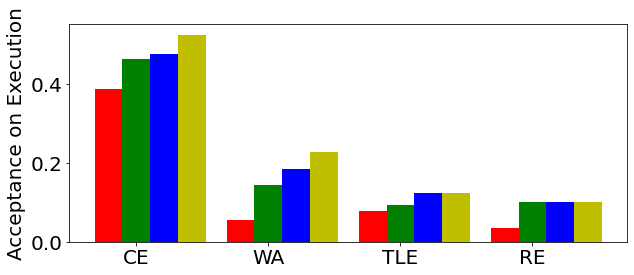

In [75]:

import numpy as np
import matplotlib.pyplot as plt

N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.21       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

top_1s, top_3s, top_5s, top_10s =  [], [], [], []
counts = []
for i in ['Compile Error', 'Wrong Answer', 'Time Limit Exceeded', 'Runtime Error']:
    top_1s.append(verdict_top_at_acc[i]['top_1'])
    top_3s.append(verdict_top_at_acc[i]['top_3'])
    top_5s.append(verdict_top_at_acc[i]['top_5'])
    top_10s.append(verdict_top_at_acc[i]['top_10'])
    counts.append(verdict_count[i])

print(top_1s)
print(counts)
rects1 = ax.bar(ind, [x/y for x, y in zip(top_1s, counts)], width, color='r')


rects2 = ax.bar(ind+width, [x/y for x, y in zip(top_3s, counts)], width, color='g')

rects3 = ax.bar(ind+width*2, [x/y for x, y in zip(top_5s, counts)], width, color='b')

rects4 = ax.bar(ind+width*3, [x/y for x, y in zip(top_10s, counts)], width, color='y')



ax.set_ylabel('Acceptance on Execution')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('CE', 'WA', 'TLE', 'RE'))
#ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)
plt.savefig('Acceptance_By_Verdict.pdf', format='pdf', dpi=1200)
#plt.show()

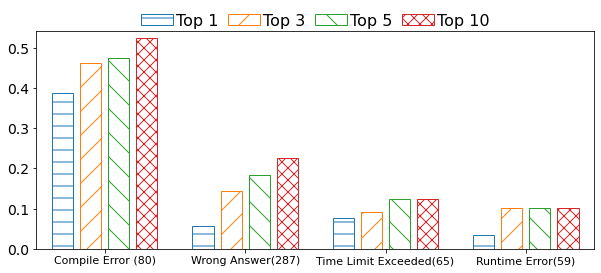

In [76]:
xlabels = [
    f'Compile Error ({verdict_count["Compile Error"]})', f'Wrong Answer({verdict_count["Wrong Answer"]})', f'Time Limit Exceeded({verdict_count["Time Limit Exceeded"]})',\
            f'Runtime Error({verdict_count["Runtime Error"]})'
]

# plt.figure(figsize=(6, 15))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "20"
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax = plt.subplots()

data = {
    'Top 1': [x/y for x, y in zip(top_1s, counts)],
    'Top 3': [x/y for x, y in zip(top_3s, counts)],
    'Top 5': [x/y for x, y in zip(top_5s, counts)],
    'Top 10': [x/y for x, y in zip(top_10s, counts)],
}

bar_plot(
    ax, data,
    total_width=0.8,
    single_width=0.75,
    xlabels=xlabels,
    hatches=('-', '/', '\\', 'xx')
)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=14)
plt.margins(0.03, 0.03)
plt.savefig('Acceptance_By_Verdict_java.pdf', format='pdf', dpi=1200, bbox_inches='tight', pad_inches=0)


<h2> Graph gen for java with difficulty</h2>

In [1]:
import pandas as pd
from collections import defaultdict
problemlist=pd.read_csv('problem_list.csv')
problems = defaultdict(list)
for index, row in problemlist.iterrows():
    if(row['dataset']=='AtCoder'):
        if("AtCoder Regular Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ARC"+number].append(row['id'])
        if("AtCoder Beginner Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ABC"+number].append(row['id'])
        if("AtCoder Grand Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["AGC"+number].append(row['id'])

#print(problems)
difficulty = {}
for key in problems.keys():
    for idx, id in enumerate(problems[key]):
        difficulty[id] = idx+1
print(difficulty)


{'p02546': 1, 'p02547': 2, 'p02548': 3, 'p02549': 4, 'p02550': 5, 'p02551': 6, 'p02552': 1, 'p02553': 2, 'p02554': 3, 'p02555': 4, 'p02556': 5, 'p02557': 6, 'p02570': 1, 'p02571': 2, 'p02572': 3, 'p02573': 4, 'p02574': 5, 'p02575': 6, 'p02576': 1, 'p02577': 2, 'p02578': 3, 'p02579': 4, 'p02580': 5, 'p02581': 6, 'p02582': 1, 'p02583': 2, 'p02584': 3, 'p02585': 4, 'p02586': 5, 'p02587': 6, 'p02588': 1, 'p02589': 2, 'p02590': 3, 'p02591': 4, 'p02592': 5, 'p02593': 6, 'p02594': 1, 'p02595': 2, 'p02596': 3, 'p02597': 4, 'p02598': 5, 'p02599': 6, 'p02612': 1, 'p02613': 2, 'p02614': 3, 'p02615': 4, 'p02616': 5, 'p02617': 6, 'p02621': 1, 'p02622': 2, 'p02623': 3, 'p02624': 4, 'p02625': 5, 'p02626': 6, 'p02627': 1, 'p02628': 2, 'p02629': 3, 'p02630': 4, 'p02631': 5, 'p02632': 6, 'p02633': 1, 'p02634': 2, 'p02635': 3, 'p02636': 4, 'p02637': 5, 'p02638': 6, 'p02639': 1, 'p02640': 2, 'p02641': 3, 'p02642': 4, 'p02643': 5, 'p02644': 6, 'p02651': 1, 'p02652': 2, 'p02653': 3, 'p02654': 4, 'p02655': 5

In [78]:
import json
from pprint import pprint
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data

data = getJsonData('FINAL_RESULT_java2java_with_verdict.json')

difficulty_top_at_acc = {}
tops = {}
tops['top_1'] = 0
tops['top_3'] = 0
tops['top_5'] = 0
tops['top_10'] = 0
diff_count = {}
for idx in range(1, 7):
    diff_count[idx] = 0
    #print(eval[dt['idx']]['src_verdict'])
    difficulty_top_at_acc[idx] = tops.copy()

top_1, top_3 , top_5, top_10= 0, 0, 0, 0
before = 0
accepted_before = []

for ind, dt in enumerate(data):
    diff_count[difficulty[data[ind]['tgt_id'].split('_')[0]]]+=1
    counted_once = [False, False, False, False]
    for idx in range(10):
        if dt['test_cases_run_by_generations'][idx]==dt['total_test_cases']:
            if not counted_once[0] and idx<1:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_1'] +=1
                counted_once[0]=True
            if not counted_once[1] and idx<3:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_3'] +=1
                counted_once[1]=True
            if not counted_once[2] and idx<5:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_5'] +=1
                counted_once[2]=True
            if not counted_once[3] and idx<10:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_10']+=1
                counted_once[3]=True

print(difficulty_top_at_acc)
print(diff_count)


{1: {'top_1': 29, 'top_3': 39, 'top_5': 43, 'top_10': 45}, 2: {'top_1': 7, 'top_3': 16, 'top_5': 21, 'top_10': 25}, 3: {'top_1': 13, 'top_3': 27, 'top_5': 32, 'top_10': 41}, 4: {'top_1': 4, 'top_3': 7, 'top_5': 8, 'top_10': 9}, 5: {'top_1': 1, 'top_3': 1, 'top_5': 1, 'top_10': 1}, 6: {'top_1': 0, 'top_3': 0, 'top_5': 0, 'top_10': 0}}
{1: 116, 2: 104, 3: 164, 4: 85, 5: 16, 6: 6}


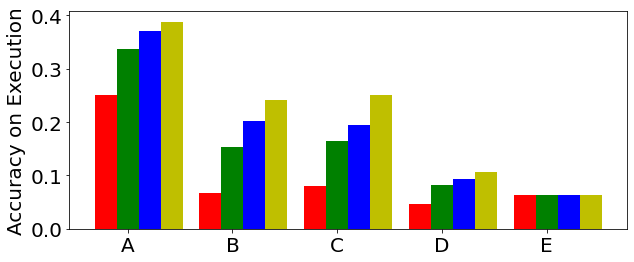

In [79]:

import numpy as np
import matplotlib.pyplot as plt

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.21       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

top_1s, top_3s, top_5s, top_10s =  [], [], [], []
counts = []
for i in range(1, 6):
    top_1s.append(difficulty_top_at_acc[i]['top_1'])
    top_3s.append(difficulty_top_at_acc[i]['top_3'])
    top_5s.append(difficulty_top_at_acc[i]['top_5'])
    top_10s.append(difficulty_top_at_acc[i]['top_10'])
    counts.append(diff_count[i])

rects1 = ax.bar(ind, [x/y for x, y in zip(top_1s, counts)], width, color='r')


rects2 = ax.bar(ind+width, [x/y for x, y in zip(top_3s, counts)], width, color='g')

rects3 = ax.bar(ind+width*2, [x/y for x, y in zip(top_5s, counts)], width, color='b')

rects4 = ax.bar(ind+width*3, [x/y for x, y in zip(top_10s, counts)], width, color='y')



ax.set_ylabel('Accuracy on Execution')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('A', 'B', 'C', 'D', 'E') )
#ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)
plt.savefig('Acceptance_By_Difficulty.pdf', format='pdf', dpi=1200)
#plt.show()

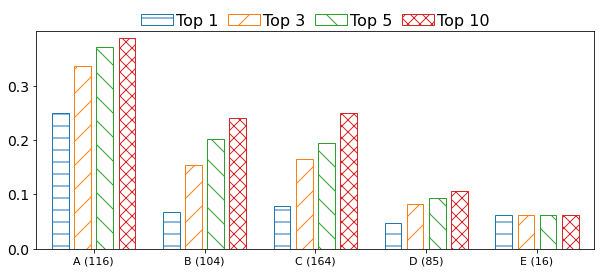

In [80]:
xlabels = [
    f'A ({diff_count[1]})', f'B ({diff_count[2]})', f'C ({diff_count[3]})',f'D ({diff_count[4]})', f'E ({diff_count[5]})'
]

# plt.figure(figsize=(6, 15))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "20"
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax = plt.subplots()

data = {
    'Top 1': [x/y for x, y in zip(top_1s, counts)],
    'Top 3': [x/y for x, y in zip(top_3s, counts)],
    'Top 5': [x/y for x, y in zip(top_5s, counts)],
    'Top 10': [x/y for x, y in zip(top_10s, counts)],
}

bar_plot(
    ax, data,
    total_width=0.8,
    single_width=0.75,
    xlabels=xlabels,
    hatches=('-', '/', '\\', 'xx')
)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=14)
plt.margins(0.03, 0.03)
plt.savefig('Acceptance_By_Difficulty_java.pdf', format='pdf', dpi=1200, bbox_inches='tight', pad_inches=0)


In [5]:
%matplotlib inline

<h2> Acceptance By verdict Python</h2>

In [81]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys
import json
root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)
pyprocessor = PythonProcessor(root_folder=root_folder)
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
eval = getJsonData('../data/python/processed/eval.jsonl')
print(len(eval))

500


In [82]:
import json

from pprint import pprint
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data

data = getJsonData('FINAL_RESULT_python2python_with_verdict.json')
print(len(data))
verdict_top_at_acc = {}
tops = {}
tops['top_1'] = 0
tops['top_3'] = 0
tops['top_5'] = 0
tops['top_10'] = 0
verdict_count = {}
for dt in data:
    #print(eval[dt['idx']]['src_verdict'])
    verdict_top_at_acc[eval[dt['idx']]['src_verdict']] = tops.copy()
    verdict_count[eval[dt['idx']]['src_verdict']] = 0

print(verdict_count)

top_1, top_3 , top_5, top_10= 0, 0, 0, 0
before = 0
accepted_before = []

for ind, dt in enumerate(data):
    verdict_count[eval[dt['idx']]['src_verdict']]+=1
    counted_once = [False, False, False, False]
    for idx in range(10):
        if dt['test_cases_run_by_generations'][idx]==dt['total_test_cases']:
            if not counted_once[0] and idx<1:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_1'] +=1
                counted_once[0]=True
            if not counted_once[1] and idx<3:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_3'] +=1
                counted_once[1]=True
            if not counted_once[2] and idx<5:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_5'] +=1
                counted_once[2]=True
            if not counted_once[3] and idx<10:
                verdict_top_at_acc[eval[dt['idx']]['src_verdict']]['top_10'] +=1
                counted_once[3]=True
            
print(verdict_top_at_acc)
print(verdict_count)
print(list(verdict_count.keys()))


468
{'Runtime Error': 0, 'Wrong Answer': 0, 'Time Limit Exceeded': 0, 'Judge Not Available': 0}
{'Runtime Error': {'top_1': 23, 'top_3': 30, 'top_5': 30, 'top_10': 34}, 'Wrong Answer': {'top_1': 22, 'top_3': 37, 'top_5': 47, 'top_10': 54}, 'Time Limit Exceeded': {'top_1': 7, 'top_3': 9, 'top_5': 10, 'top_10': 12}, 'Judge Not Available': {'top_1': 0, 'top_3': 0, 'top_5': 0, 'top_10': 0}}
{'Runtime Error': 94, 'Wrong Answer': 271, 'Time Limit Exceeded': 102, 'Judge Not Available': 1}
['Runtime Error', 'Wrong Answer', 'Time Limit Exceeded', 'Judge Not Available']


[23, 22, 7]
[94, 271, 102]


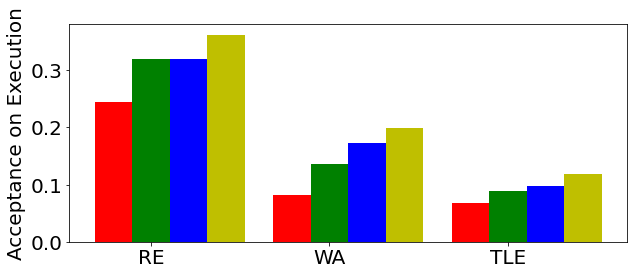

In [83]:

import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.21       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

top_1s, top_3s, top_5s, top_10s =  [], [], [], []
counts = []
for i in ['Runtime Error', 'Wrong Answer', 'Time Limit Exceeded']:
    top_1s.append(verdict_top_at_acc[i]['top_1'])
    top_3s.append(verdict_top_at_acc[i]['top_3'])
    top_5s.append(verdict_top_at_acc[i]['top_5'])
    top_10s.append(verdict_top_at_acc[i]['top_10'])
    counts.append(verdict_count[i])

print(top_1s)
print(counts)
rects1 = ax.bar(ind, [x/y for x, y in zip(top_1s, counts)], width, color='r')


rects2 = ax.bar(ind+width, [x/y for x, y in zip(top_3s, counts)], width, color='g')

rects3 = ax.bar(ind+width*2, [x/y for x, y in zip(top_5s, counts)], width, color='b')

rects4 = ax.bar(ind+width*3, [x/y for x, y in zip(top_10s, counts)], width, color='y')



ax.set_ylabel('Acceptance on Execution')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('RE', 'WA', 'TLE'))
#ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)
plt.savefig('Acceptance_By_Verdict.pdf', format='pdf', dpi=1200)
#plt.show()

#verdict_top_at_acc['Judge Not Available']['top_10']

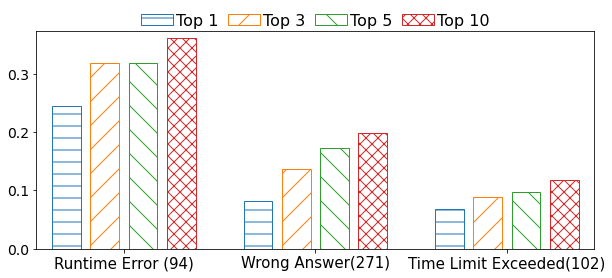

In [84]:
xlabels = [
    f'Runtime Error ({verdict_count["Runtime Error"]})', f'Wrong Answer({verdict_count["Wrong Answer"]})', f'Time Limit Exceeded({verdict_count["Time Limit Exceeded"]})'
            
]

# plt.figure(figsize=(6, 15))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "20"
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax = plt.subplots()

data = {
    'Top 1': [x/y for x, y in zip(top_1s, counts)],
    'Top 3': [x/y for x, y in zip(top_3s, counts)],
    'Top 5': [x/y for x, y in zip(top_5s, counts)],
    'Top 10': [x/y for x, y in zip(top_10s, counts)],
}

bar_plot(
    ax, data,
    total_width=0.8,
    single_width=0.75,
    xlabels=xlabels,
    hatches=('-', '/', '\\', 'xx')
)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=14)
plt.margins(0.03, 0.03)
plt.savefig('Acceptance_By_Verdict_python.pdf', format='pdf', dpi=1200, bbox_inches='tight', pad_inches=0)


<h2> ACceptance by difficult Python</h2>

In [85]:
import pandas as pd
from collections import defaultdict
problemlist=pd.read_csv('problem_list.csv')
problems = defaultdict(list)
for index, row in problemlist.iterrows():
    if(row['dataset']=='AtCoder'):
        if("AtCoder Regular Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ARC"+number].append(row['id'])
        if("AtCoder Beginner Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["ABC"+number].append(row['id'])
        if("AtCoder Grand Contest" in row['name']):
            number = row['name'].split(" ")[3]
            problems["AGC"+number].append(row['id'])

#print(problems)
difficulty = {}
for key in problems.keys():
    for idx, id in enumerate(problems[key]):
        difficulty[id] = idx+1
#print(difficulty)


In [86]:
import json
from pprint import pprint
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data

data = getJsonData('FINAL_RESULT_python2python_with_verdict.json')

difficulty_top_at_acc = {}
tops = {}
tops['top_1'] = 0
tops['top_3'] = 0
tops['top_5'] = 0
tops['top_10'] = 0
diff_count = {}
for idx in range(1, 7):
    diff_count[idx] = 0
    #print(eval[dt['idx']]['src_verdict'])
    difficulty_top_at_acc[idx] = tops.copy()

top_1, top_3 , top_5, top_10= 0, 0, 0, 0
before = 0
accepted_before = []

for ind, dt in enumerate(data):
    diff_count[difficulty[data[ind]['tgt_id'].split('_')[0]]]+=1
    counted_once = [False, False, False, False]
    for idx in range(10):
        if dt['test_cases_run_by_generations'][idx]==dt['total_test_cases']:
            if not counted_once[0] and idx<1:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_1'] +=1
                counted_once[0]=True
            if not counted_once[1] and idx<3:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_3'] +=1
                counted_once[1]=True
            if not counted_once[2] and idx<5:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_5'] +=1
                counted_once[2]=True
            if not counted_once[3] and idx<10:
                difficulty_top_at_acc[difficulty[data[ind]['tgt_id'].split('_')[0]]]['top_10']+=1
                counted_once[3]=True

print(difficulty_top_at_acc)
print(diff_count)



{1: {'top_1': 18, 'top_3': 24, 'top_5': 25, 'top_10': 30}, 2: {'top_1': 7, 'top_3': 11, 'top_5': 13, 'top_10': 16}, 3: {'top_1': 14, 'top_3': 25, 'top_5': 30, 'top_10': 35}, 4: {'top_1': 9, 'top_3': 12, 'top_5': 13, 'top_10': 13}, 5: {'top_1': 4, 'top_3': 4, 'top_5': 6, 'top_10': 6}, 6: {'top_1': 0, 'top_3': 0, 'top_5': 0, 'top_10': 0}}
{1: 81, 2: 80, 3: 171, 4: 97, 5: 26, 6: 13}


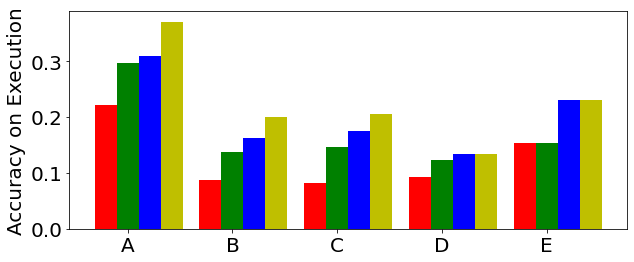

In [87]:

import numpy as np
import matplotlib.pyplot as plt

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.21       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

top_1s, top_3s, top_5s, top_10s =  [], [], [], []
counts = []
for i in range(1, 6):
    top_1s.append(difficulty_top_at_acc[i]['top_1'])
    top_3s.append(difficulty_top_at_acc[i]['top_3'])
    top_5s.append(difficulty_top_at_acc[i]['top_5'])
    top_10s.append(difficulty_top_at_acc[i]['top_10'])
    counts.append(diff_count[i])

rects1 = ax.bar(ind, [x/y for x, y in zip(top_1s, counts)], width, color='r')


rects2 = ax.bar(ind+width, [x/y for x, y in zip(top_3s, counts)], width, color='g')

rects3 = ax.bar(ind+width*2, [x/y for x, y in zip(top_5s, counts)], width, color='b')

rects4 = ax.bar(ind+width*3, [x/y for x, y in zip(top_10s, counts)], width, color='y')



ax.set_ylabel('Accuracy on Execution')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('A', 'B', 'C', 'D', 'E') )
#ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)
plt.savefig('Acceptance_By_Difficulty.pdf', format='pdf', dpi=1200)
#plt.show()

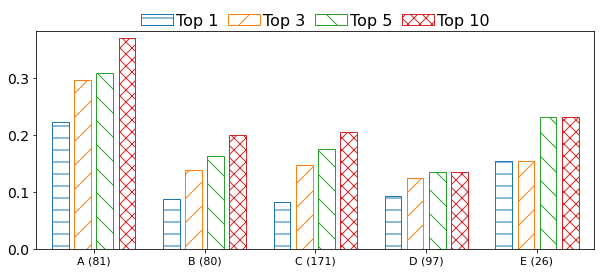

In [88]:
xlabels = [
    f'A ({diff_count[1]})', f'B ({diff_count[2]})', f'C ({diff_count[3]})',f'D ({diff_count[4]})', f'E ({diff_count[5]})'
]

# plt.figure(figsize=(6, 15))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "20"
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax = plt.subplots()

data = {
    'Top 1': [x/y for x, y in zip(top_1s, counts)],
    'Top 3': [x/y for x, y in zip(top_3s, counts)],
    'Top 5': [x/y for x, y in zip(top_5s, counts)],
    'Top 10': [x/y for x, y in zip(top_10s, counts)],
}

bar_plot(
    ax, data,
    total_width=0.8,
    single_width=0.75,
    xlabels=xlabels,
    hatches=('-', '/', '\\', 'xx')
)
ax.xaxis.set_tick_params(labelsize=11)
ax.yaxis.set_tick_params(labelsize=14)
plt.margins(0.03, 0.03)
plt.savefig('Acceptance_By_Difficulty_python.pdf', format='pdf', dpi=1200, bbox_inches='tight', pad_inches=0)


In [14]:
difficulty_top_at_acc[5]['top_3']

4

In [16]:
diff_count

{1: 81, 2: 80, 3: 171, 4: 97, 5: 26, 6: 13}

In [70]:
from codegen.preprocessing.lang_processors.java_processor import JavaProcessor
from codegen.preprocessing.lang_processors.python_processor import PythonProcessor
import subprocess
import filecmp
from subprocess import Popen, PIPE, STDOUT
import sys
import json
root_folder = "../third_party"
jprocessor = JavaProcessor(root_folder=root_folder)
pyprocessor = PythonProcessor(root_folder=root_folder)
def getJsonData(JsonFile):
    with open(JsonFile, encoding="utf8") as f:
        data = json.load(f)
    return data
#test = getJsonData('../data/python/processed/test.jsonl')
eval = getJsonData('../data/python/processed/eval.jsonl')


{'src_id': 'p03423_s483140324', 'src': ['N', '=', 'int', '(', 'input', '(', ')', ')', 'NEW_LINE', 'print', '(', 'N', '//', '3', ')', 'NEW_LINE'], 'src_verdict': 'Judge Not Available', 'tgt': ['N', '=', 'int', '(', 'input', '(', ')', ')', 'NEW_LINE', 'print', '(', 'N', '//', '3', ')', 'NEW_LINE'], 'tgt_id': 'p03423_s214143093'}


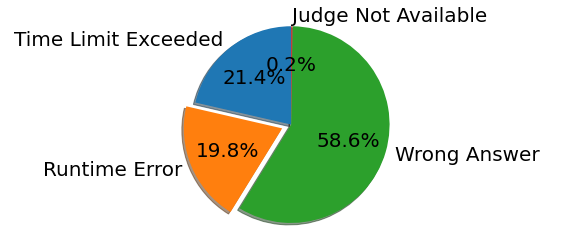

In [89]:

counts = {}
for data in eval:
        counts[data['src_verdict']] = counts.get(data['src_verdict'], 0)+1
        if data['src_verdict'] == 'Judge Not Available':
                print(data)

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(counts.keys())
sizes = [counts[key] for key in labels]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes,explode=explode,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [24]:
res = getJsonData('FINAL_RESULT_python2python_with_verdict.json')

counts = {}
for data in eval:
        counts[data['src_verdict']] = counts.get(data['src_verdict'], 0)+1
print(counts)

{'Time Limit Exceeded': 67, 'Compile Error': 80, 'Wrong Answer': 293, 'Runtime Error': 60}


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


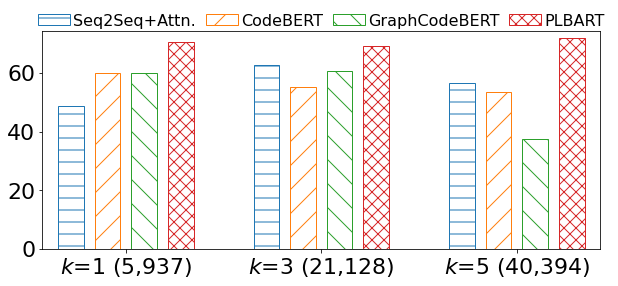

In [30]:
import pickle
from statistics import mean, median
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt

COLORS = [
    'tab:gray', 'tab:orange', 'tab:blue', 'tab:red',
    'tab:purple', 'tab:cyan', 'tab:olive', 'tab:green',
]


def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, xlabels=None, legend=True, hatches=None):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if hatches:
        assert len(hatches) == len(data)
    else:
        hatches = ['|'] * len(data)

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    x_coord = []
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            if i == 0:
                x_coord.append(x + (x_offset + (bar_width * 3) / 2))

            bar = ax.bar(
                x + x_offset, y,
                bar_width * single_width,
                color='white',
                edgecolor=colors[i % len(colors)],
                # color=colors[i % len(colors)],
                hatch=hatches[i] if hatches else None,
                align='center',
                # alpha=0.7,
            )

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    if xlabels:
        ax.set(xticks=x_coord, xticklabels=xlabels)

    # Draw legend if we need
    if legend:
        ax.legend(
            bars,
            data.keys(),
            loc='upper center',
            bbox_to_anchor=(0.5, 1.15),
            ncol=len(data),
            columnspacing=0.6,
            handletextpad=0.2,
            fontsize=16,
            frameon=False
        )

    # ratio= 1.0
    # xleft, xright = ax.get_xlim()
    # ybottom, ytop = ax.get_ylim()
    # # the abs method is used to make sure that all numbers are positive
    # # because x and y axis of an axes maybe inversed.
    # ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)


if __name__ == '__main__':
    xlabels = [
        '$k$=1 (5,937)', '$k$=3 (21,128)', '$k$=5 (40,394)',
    ]

    # plt.figure(figsize=(6, 15))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "20"
    plt.rcParams["figure.figsize"] = [10, 4]
    fig, ax = plt.subplots()

    # label = 'Java_to_Python'
    # data = {
    #     'Seq2Seq+Attn.': [43.4, 56.3, 52.8],
    #     'CodeBERT': [55.7, 59.3, 55.9],
    #     'GraphCodeBERT': [58.5, 59.7, 58.6],
    #     'PLBART': [58.4, 67.1, 59.6],
    # }

    label = 'Python_to_Java'
    data = {
        'Seq2Seq+Attn.': [48.7, 62.7, 56.6],
        'CodeBERT': [59.9, 55.3, 53.4],
        'GraphCodeBERT': [59.8, 60.6, 37.4],
        'PLBART': [70.6, 69.1, 72.0],
    }

    bar_plot(
        ax, data,
        total_width=0.75,
        single_width=0.7,
        xlabels=xlabels,
        hatches=('-', '/', '\\', 'xx')
    )
    ax.xaxis.set_tick_params(labelsize=22)
    ax.yaxis.set_tick_params(labelsize=22)
    plt.margins(0.03, 0.03)
    plt.savefig(
        '{}.pdf'.format(label), bbox_inches='tight',
        pad_inches=0
    )

In [97]:
data = getJsonData('FINAL_RESULT_python2python_with_verdict.json')
#print(data[0])
for dt in data[150:200]:
    if dt['test_cases_run_by_generations'][0]==dt['total_test_cases']:
        print("##########    src    ###########")
        print(dt['detokenized_src'])
        #print(dt['detokenized_generations'][0])
        print('##########    tgt    ###########')
        print(dt['detokenized_tgt'])
        
        

##########    src    ###########
import math
from functools import reduce
N = int ( input ( ) )
T = [ int ( input ( ) ) for _ in range ( N ) ]
def lcm_base ( x , y ) :
    return ( x * y ) // math.gcd ( x , y )
def lcm ( L ) :
    return reduce ( lcm_base , L , 1 )
print ( lcm ( T ) )

##########    tgt    ###########
import fractions
from functools import reduce
N = int ( input ( ) )
T = [ int ( input ( ) ) for _ in range ( N ) ]
def lcm_base ( x , y ) :
    return ( x * y ) // fractions.gcd ( x , y )
def lcm ( L ) :
    return reduce ( lcm_base , L , 1 )
print ( lcm ( T ) )

##########    src    ###########
import math
nums = list ( map ( int , input ( ).split ( " " ) ) )
g = math.gcd ( nums [ 0 ] , nums [ 1 ] )
arr = [ 0 for i in range ( 100 ) ]
a = 0
for i in range ( 100 ) :
    i += 1
    if nums [ 0 ] % i == 0 and nums [ 1 ] % i == 0 :
        arr [ a ] = i
        a += 1
        if i == g :
            print ( arr [ a - nums [ 2 ] ] )
            break

##########    tgt    ####